In [2]:
cd /Users/james/signal

/Users/james/signal


In [3]:
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from beakerx import *
plt.style.use('ggplot')
import seaborn as sns
sns.set()
import h5py
import os
from tqdm import tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/Users/james/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import matplotlib.pyplot as plt # creating visualizations
import numpy as np # basic math and random numbers
import torch # package for building functions with learnable parameters
import torch.nn as nn # prebuilt functions specific to neural networks
from torch.autograd import Variable # storing data while learning
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from edward.models import Categorical, Mixture, Normal
from scipy import stats
from sklearn.model_selection import train_test_split

Then we generate random inputs $x$ to get random samples of $y(x)$. Later we will train a neural net on this data.

Size of features in training data: (750, 6)
Size of output in training data: (750, 2)
Size of features in test data: (250, 6)
Size of output in test data: (250, 2)


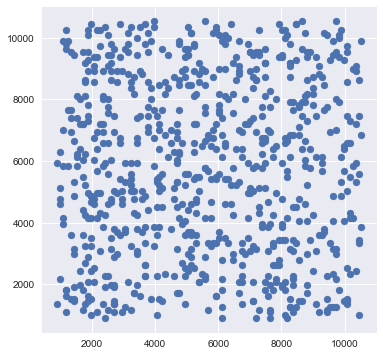

In [5]:
def prepare_dataset(featurename='rss'):
    import scipy.io as sio  
    data_1 = sio.loadmat('data_paper_WSNL/1000data.mat')
    data_2 = sio.loadmat('data_paper_WSNL/TXRXLoc2000.mat')
    local = data_2['RXm'][:1000,:2]
    rss = data_1['data_db_rss']
    aoa = data_1['data_db_aoa']
    toa = data_1['data_db_toa']
    data_4 = data_1['data'][:,18:24]
    data_5 = data_1['data'][:,24:]
    data_whole = np.concatenate((rss,aoa,toa,data_4,data_5),axis =1)
    local_x = local[:,:1]
    local_y = local[:,1:]
    if featurename=='whole':
        return train_test_split(data_whole, local, random_state=42)
    elif featurename=='rss':
        return train_test_split(rss, local, random_state=42)
    elif featurename=='aoa':
        return train_test_split(aoa, local, random_state=42)
    elif featurename=='toa':
        return train_test_split(toa, local, random_state=42)
    elif featurename=='data_4':
        return train_test_split(data_4, local, random_state=42)
    elif featurename=='data_5':
        return train_test_split(data_4, local, random_state=42)

ed.set_seed(42)


X_train, X_test, y_train, y_test = prepare_dataset(featurename='toa')
print("Size of features in training data: {}".format(X_train.shape))
print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))
fig,ax=plt.subplots(1,figsize=(6,6))
ax.scatter(y_train[:,0], y_train[:,1])
plt.show()

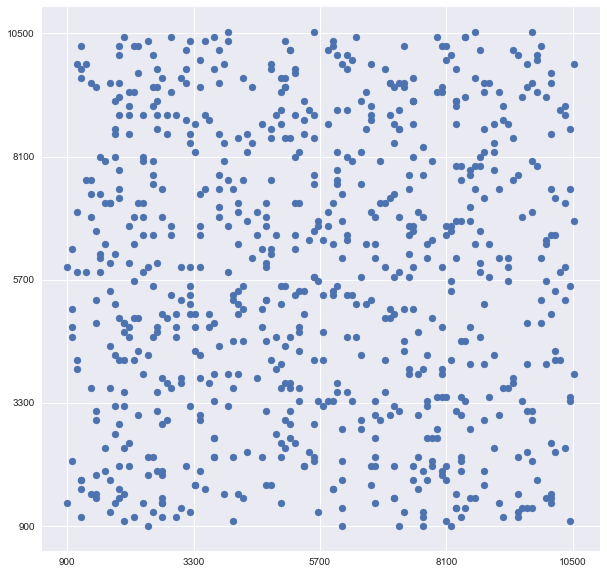

In [6]:
fig,ax = plt.subplots(1,figsize=(10,10))
ax.scatter(y_train[:,0],y_train[:,1])
ax.set_xticks(np.arange(900,10530,2400))
ax.set_yticks(np.arange(900,10530,2400))

# 基本部分，MLP网络

In [47]:
class mlp_train():
    def __init__(self,n_input = 6,n_hidden_1 = 4,n_hidden_2 = 3,n_output = 2,n_samples=750,epoch_num=100000):
        self.n_input = n_input
        self.n_hidden_1 = n_hidden_1
        self.n_hidden_2 = n_hidden_2
        self.n_output = n_output
        self.n_samples = n_samples
        self.epoch_num = epoch_num
        self.loss_fn = nn.MSELoss()
    def MLP(self):
        network = nn.Sequential(nn.Linear(self.n_input, self.n_hidden_1),
                        nn.ReLU(),nn.Linear(self.n_hidden_1, self.n_hidden_2),nn.ReLU(),
                        nn.Linear(self.n_hidden_2, self.n_output))
        self.optimizer = torch.optim.RMSprop(network.parameters())
        return network
    def train(self):
        self.mlpnetwork = self.MLP()
        x_tensor = torch.from_numpy(np.float32(X_train).reshape(self.n_samples, self.n_input))
        y_tensor = torch.from_numpy(np.float32(y_train).reshape(self.n_samples, self.n_output))
        x_variable = Variable(x_tensor)
        y_variable = Variable(y_tensor, requires_grad=False)
        lossarr = np.ndarray([int(self.epoch_num/500),2])
        for epoch in tqdm(range(self.epoch_num)):
            y_pred = self.mlpnetwork(x_variable) # make a prediction
            loss = self.loss_fn(y_pred, y_variable) # compute the loss
            self.optimizer.zero_grad() # prepare the optimizer
            loss.backward() # compute the contribution of each parameter to the loss
            self.optimizer.step() # modify the parameters

            if epoch % 500 == 0:
                lossarr[int(epoch/500),0],lossarr[int(epoch/500),1] = epoch, loss.data[0].numpy()
                print(epoch, loss.data[0].numpy())
        return lossarr
    def report_metrics(self):
        lossarr = self.train()
        x_test_data = X_test
        x_test_tensor = torch.from_numpy(np.float32(x_test_data).reshape(250, n_input))
        x_test_variable = Variable(x_test_tensor)
        y_test_variable = self.mlpnetwork(x_test_variable)
        y_test_data = y_test_variable.data.numpy()
        rmse = np.mean(np.sum((y_test_data - y_test)**2,axis=1)**0.5)
        pcc = scipy.stats.pearsonr(y_test_data.ravel(),y_test.ravel())
        return rmse,pcc,lossarr

In [ ]:
mlptrain = mlp_train(epoch_num=1000000)
rmse,pcc,loss = mlptrain.report_metrics()


  0%|          | 190/1000000 [00:00<09:07, 1825.03it/s]


0 39908190.0


  0%|          | 655/1000000 [00:00<10:23, 1602.85it/s]

500 11570108.0



  0%|          | 1259/1000000 [00:00<09:22, 1774.47it/s]

1000 7102331.0



  0%|          | 1797/1000000 [00:01<09:34, 1737.58it/s]

1500 5477693.0



  0%|          | 2307/1000000 [00:01<09:45, 1702.64it/s]

2000 4374938.5



  0%|          | 2887/1000000 [00:01<09:31, 1744.01it/s]

2500 4084086.5



  0%|          | 3304/1000000 [00:01<09:20, 1777.89it/s]

3000 4070081.2



  0%|          | 3693/1000000 [00:02<09:21, 1774.34it/s]

3500 4069514.2



  0%|          | 4260/1000000 [00:02<09:27, 1755.38it/s]

4000 4069322.8



  0%|          | 4839/1000000 [00:02<09:21, 1771.61it/s]

4500 4069151.0



  1%|          | 5227/1000000 [00:02<09:24, 1762.07it/s]

5000 4068987.5



  1%|          | 5751/1000000 [00:03<09:35, 1728.41it/s]

5500 4068826.5



  1%|          | 6347/1000000 [00:03<09:29, 1743.57it/s]

6000 4068666.0



  1%|          | 6709/1000000 [00:03<09:32, 1733.75it/s]

6500 4068502.5



  1%|          | 7269/1000000 [00:04<09:30, 1738.63it/s]

7000 4068341.5



  1%|          | 7816/1000000 [00:04<09:31, 1737.12it/s]

7500 4068176.5



  1%|          | 8318/1000000 [00:05<09:56, 1662.84it/s]

8000 4068014.8



  1%|          | 8860/1000000 [00:05<09:53, 1670.70it/s]

8500 4067847.2



  1%|          | 9186/1000000 [00:05<10:06, 1634.70it/s]

9000 4067687.0



  1%|          | 9610/1000000 [00:05<10:15, 1609.87it/s]

9500 4067525.2



  1%|          | 10304/1000000 [00:06<10:23, 1586.10it/s]

10000 4067359.5



  1%|          | 10609/1000000 [00:06<10:30, 1569.64it/s]

10500 4067197.2



  1%|          | 11331/1000000 [00:07<10:24, 1581.91it/s]

11000 4067029.2



  1%|          | 11718/1000000 [00:07<10:21, 1588.97it/s]


11500 4066871.0


  1%|          | 12334/1000000 [00:07<10:15, 1605.65it/s]

12000 4066708.8



  1%|▏         | 12732/1000000 [00:07<10:12, 1611.65it/s]

12500 4066539.8



  1%|▏         | 13299/1000000 [00:08<10:10, 1616.39it/s]

13000 4066376.2



  1%|▏         | 13905/1000000 [00:08<10:04, 1630.50it/s]

13500 4066215.2



  1%|▏         | 14368/1000000 [00:08<09:58, 1646.12it/s]

14000 4066044.5



  1%|▏         | 14788/1000000 [00:08<09:57, 1649.70it/s]

14500 4065887.2



  2%|▏         | 15197/1000000 [00:09<09:53, 1658.32it/s]

15000 4065720.2



  2%|▏         | 15857/1000000 [00:09<09:48, 1671.68it/s]

15500 4065554.0



  2%|▏         | 16278/1000000 [00:09<09:46, 1677.40it/s]

16000 4065381.5



  2%|▏         | 16915/1000000 [00:10<09:42, 1686.88it/s]

16500 4065221.0



  2%|▏         | 17339/1000000 [00:10<09:39, 1695.26it/s]

17000 4065057.0



  2%|▏         | 17787/1000000 [00:10<09:36, 1704.54it/s]

17500 4064893.5



  2%|▏         | 18227/1000000 [00:10<09:33, 1711.38it/s]


18000 4064722.5


  2%|▏         | 18908/1000000 [00:10<09:28, 1725.73it/s]

18500 4064558.0



  2%|▏         | 19349/1000000 [00:11<09:26, 1732.57it/s]

19000 4064393.5



  2%|▏         | 19773/1000000 [00:11<09:24, 1736.49it/s]

19500 4064223.5



  2%|▏         | 20201/1000000 [00:11<09:22, 1740.52it/s]

20000 4064055.8



  2%|▏         | 20839/1000000 [00:11<09:20, 1747.20it/s]

20500 4063891.8



  2%|▏         | 21246/1000000 [00:12<09:19, 1748.57it/s]

21000 4063726.5



  2%|▏         | 21886/1000000 [00:12<09:16, 1756.39it/s]

21500 4063554.2



  2%|▏         | 22301/1000000 [00:12<09:15, 1761.05it/s]

22000 4063389.0



  2%|▏         | 22735/1000000 [00:12<09:14, 1763.91it/s]


22500 4063221.8


  2%|▏         | 23375/1000000 [00:13<09:12, 1769.02it/s]

23000 4063059.8



  2%|▏         | 23783/1000000 [00:13<09:11, 1771.15it/s]

23500 4062888.5



  2%|▏         | 24464/1000000 [00:13<09:07, 1780.51it/s]

24000 4062722.0



  2%|▏         | 24891/1000000 [00:13<09:06, 1784.27it/s]

24500 4062552.5



  3%|▎         | 25320/1000000 [00:14<09:04, 1789.13it/s]

25000 4062384.2



  3%|▎         | 25755/1000000 [00:14<09:03, 1792.14it/s]

25500 4062212.5



  3%|▎         | 26352/1000000 [00:14<09:04, 1789.61it/s]

26000 4062040.8



  3%|▎         | 26723/1000000 [00:14<09:03, 1789.16it/s]

26500 4061874.5



  3%|▎         | 27355/1000000 [00:15<09:01, 1795.29it/s]

27000 4061711.2



  3%|▎         | 27792/1000000 [00:15<09:00, 1797.93it/s]

27500 4061540.8



  3%|▎         | 28220/1000000 [00:15<08:59, 1800.18it/s]

28000 4061374.5



  3%|▎         | 28823/1000000 [00:15<08:58, 1801.94it/s]

28500 4061202.8



  3%|▎         | 29201/1000000 [00:16<08:58, 1801.31it/s]

29000 4061030.8



  3%|▎         | 29802/1000000 [00:16<08:57, 1804.45it/s]

29500 4060867.5



  3%|▎         | 30238/1000000 [00:16<08:56, 1808.20it/s]

30000 4060694.5



  3%|▎         | 30880/1000000 [00:17<08:54, 1812.66it/s]

30500 4060525.5



  3%|▎         | 31314/1000000 [00:17<08:53, 1815.14it/s]

31000 4060350.5



  3%|▎         | 31736/1000000 [00:17<08:53, 1816.40it/s]

31500 4060187.0



  3%|▎         | 32399/1000000 [00:17<08:50, 1822.43it/s]

32000 4060014.5



  3%|▎         | 32827/1000000 [00:17<08:49, 1825.54it/s]

32500 4059846.0



  3%|▎         | 33247/1000000 [00:18<08:49, 1825.83it/s]

33000 4059681.0



  3%|▎         | 33842/1000000 [00:18<08:48, 1826.87it/s]

33500 4059503.2



  3%|▎         | 34247/1000000 [00:18<08:48, 1828.94it/s]

34000 4059335.2



  3%|▎         | 34828/1000000 [00:19<08:47, 1828.80it/s]

34500 4059161.0



  4%|▎         | 35200/1000000 [00:19<08:47, 1827.59it/s]

35000 4058991.0



  4%|▎         | 35793/1000000 [00:19<08:47, 1829.15it/s]

35500 4058825.5



  4%|▎         | 36234/1000000 [00:19<08:45, 1832.94it/s]

36000 4058646.2



  4%|▎         | 36940/1000000 [00:20<08:43, 1840.68it/s]

36500 4058481.0



  4%|▎         | 37166/1000000 [00:20<08:43, 1839.15it/s]

37000 4058305.5



  4%|▍         | 37793/1000000 [00:20<08:42, 1839.95it/s]

37500 4058137.5



  4%|▍         | 38192/1000000 [00:20<08:42, 1839.72it/s]

38000 4057966.0



  4%|▍         | 38744/1000000 [00:21<08:43, 1836.82it/s]

38500 4057795.0



  4%|▍         | 39299/1000000 [00:21<08:43, 1836.63it/s]

39000 4057622.8



  4%|▍         | 39852/1000000 [00:21<08:43, 1833.54it/s]

39500 4057450.2



  4%|▍         | 40251/1000000 [00:21<08:43, 1834.71it/s]

40000 4057272.8



  4%|▍         | 40850/1000000 [00:22<08:42, 1835.68it/s]

40500 4057102.8



  4%|▍         | 41222/1000000 [00:22<08:42, 1833.40it/s]

41000 4056931.8



  4%|▍         | 41823/1000000 [00:22<08:42, 1834.12it/s]

41500 4056763.5



  4%|▍         | 42206/1000000 [00:23<08:42, 1832.44it/s]

42000 4056586.0



  4%|▍         | 42741/1000000 [00:23<08:48, 1812.03it/s]

42500 4056413.5



  4%|▍         | 43158/1000000 [00:23<08:51, 1800.20it/s]

43000 4056244.2



  4%|▍         | 43685/1000000 [00:24<08:51, 1799.37it/s]

43500 4056071.5



  4%|▍         | 44216/1000000 [00:24<08:51, 1798.63it/s]

44000 4055895.8



  4%|▍         | 44750/1000000 [00:24<08:51, 1797.98it/s]

44500 4055721.0



  5%|▍         | 45133/1000000 [00:25<08:50, 1798.31it/s]

45000 4055553.0



  5%|▍         | 45747/1000000 [00:25<08:50, 1798.43it/s]

45500 4055374.5



  5%|▍         | 46348/1000000 [00:25<08:50, 1798.31it/s]

46000 4055207.2



  5%|▍         | 46718/1000000 [00:25<08:50, 1798.32it/s]

46500 4055030.8



  5%|▍         | 47314/1000000 [00:26<08:49, 1798.33it/s]

47000 4054856.8



  5%|▍         | 47945/1000000 [00:26<08:48, 1800.52it/s]

47500 4054685.0



  5%|▍         | 48396/1000000 [00:26<08:47, 1803.88it/s]

48000 4054506.2



  5%|▍         | 48815/1000000 [00:27<08:47, 1804.85it/s]

48500 4054338.2



  5%|▍         | 49263/1000000 [00:27<08:45, 1808.00it/s]

49000 4054154.0



  5%|▍         | 49689/1000000 [00:27<08:45, 1808.74it/s]

49500 4053986.0



  5%|▌         | 50280/1000000 [00:27<08:45, 1807.05it/s]

50000 4053810.2



  5%|▌         | 50889/1000000 [00:28<08:44, 1809.37it/s]

50500 4053637.5



  5%|▌         | 51294/1000000 [00:28<08:44, 1809.62it/s]

51000 4053466.0



  5%|▌         | 51876/1000000 [00:28<08:43, 1810.17it/s]

51500 4053288.5



  5%|▌         | 52283/1000000 [00:28<08:43, 1811.08it/s]

52000 4053110.8



  5%|▌         | 52704/1000000 [00:29<08:42, 1812.84it/s]

52500 4052936.0



  5%|▌         | 53341/1000000 [00:29<08:41, 1815.12it/s]

53000 4052767.5



  5%|▌         | 53771/1000000 [00:29<08:40, 1817.36it/s]

53500 4052588.5



  5%|▌         | 54429/1000000 [00:29<08:39, 1820.40it/s]

54000 4052410.0



  5%|▌         | 54878/1000000 [00:30<08:38, 1823.21it/s]

54500 4052241.0



  6%|▌         | 55305/1000000 [00:30<08:38, 1823.60it/s]

55000 4052063.0



  6%|▌         | 55715/1000000 [00:30<08:37, 1824.67it/s]

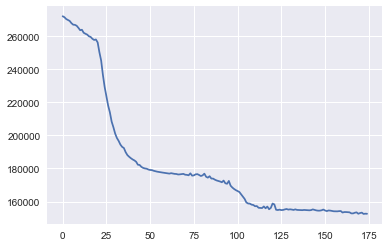

In [54]:
plt.plot(loss[25:,1])

In [ ]:
x_test_data = X_test
x_test_tensor = torch.from_numpy(np.float32(x_test_data).reshape(250, n_input))
x_test_variable = Variable(x_test_tensor)
y_test_variable = mlpnetwork(x_test_variable)
y_test_data = y_test_variable.data.numpy()
def report_metrics(y_testdat,y_predict):
    rmse = np.mean(np.sum((y_testdat - y_predict)**2,axis=1)**0.5)
    pcc = scipy.stats.pearsonr(y_testdat.ravel(),y_predict.ravel())
    return rmse,pcc
report_metrics(y_test_data,y_test)

In [7]:
def MLP():
    n_input = 6
    n_hidden_1 = 4
    n_hidden_2 = 3
    n_output = 2
    n_samples=750
    network = nn.Sequential(nn.Linear(n_input, n_hidden_1),
                        nn.ReLU(),nn.Linear(n_hidden_1, n_hidden_2),nn.ReLU(),
                        nn.Linear(n_hidden_2, n_output))
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.RMSprop(network.parameters())
    return network

In [16]:
n_samples=750
n_input = 6
n_output = 2
mlpnetwork = MLP()

In [17]:
x_tensor = torch.from_numpy(np.float32(X_train).reshape(n_samples, n_input))
y_tensor = torch.from_numpy(np.float32(y_train).reshape(n_samples, n_output))
x_variable = Variable(x_tensor)
y_variable = Variable(y_tensor, requires_grad=False)

In [24]:
scipy.stats.pearsonr(y_test_data.ravel(),y_test.ravel())
np.mean(np.sum((y_test_data - y_test)**2,axis=1)**0.5)

(-0.04449829602643857, 0.3207032860108976)

Let's see how it performs by processing some evenly spaced samples.

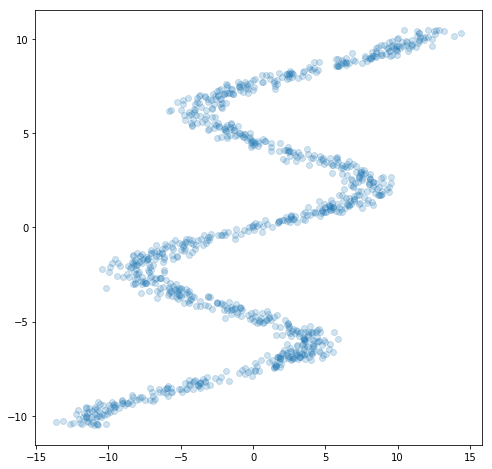

In [39]:
# plot x against y instead of y against x
plt.figure(figsize=(8, 8))
plt.scatter(y_data, x_data, alpha=0.2)
plt.show()

If we use the same method to fit this data, <span class="mark">it won't work well because the network can't output multiple values for each input. Because we used mean squared error loss, the network will try to output the average output value for each input.</span>

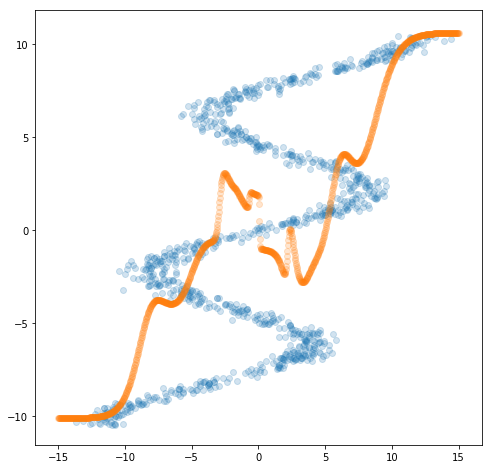

In [41]:
x_test_data = np.linspace(-15, 15, n_samples)
x_test_tensor = torch.from_numpy(np.float32(x_test_data).reshape(n_samples, n_input))
x_test_variable.data = x_test_tensor

y_test_variable = network(x_test_variable)

# move from torch back to numpy
y_test_data = y_test_variable.data.numpy()

# plot the original data and the test data
plt.figure(figsize=(8, 8))
plt.scatter(y_data, x_data, alpha=0.2)
plt.scatter(x_test_data, y_test_data, alpha=0.2)
plt.show()

Because our network only <span class="burk">predicts one output value for each input, this approach will fail miserably.</span>

What we want is a network that has the ability to predict <span class="burk">a multiple output values for each input</span>. In the next section we implement a Mixture Density Network (MDN) to achieve this task.

# Mixture Density Networks ##

Mixture Density Networks, developed by Christopher Bishop in the 1990s, **are one way to produce multiple outputs from a single input**. MDN predicts a *probability distribution* of possible output values. Then can sample several possible different output values for a given input.

This concept is quite powerful, and can be employed many current areas of machine learning research. It also allows us to calculate a sort of confidence factor in the predictions that the network is making.

The inverted sinusoid data we chose is not just a toy problem. In [the paper introducing MDNs](http://publications.aston.ac.uk/373/1/NCRG_94_004.pdf) an inverted sinusoid is used to describe the angle we need to move a robot arm to achieve a target location. MDNs are also used to model handwriting, where the next stroke is drawn from a probability distribution of multiple possibilities, rather than sticking to one prediction.

Bishop's implementation of MDNs will predict a class of probability distributions called Mixture of Gaussians or Gaussian Mixture Models, where the output value is modelled as a weighted sum of multiple Gaussians, each with different means and standard deviations.

So for each input $x$, we will predict a probability distribution function $P(y|x)$:

$P(y|x) = \sum_{k}^{K} \Pi_{k}(x) \phi(y, \mu_{k}(x), \sigma_{k}(x))$

- $k$ is an index describing which Gaussian we are referencing. There are $K$ Gaussians total.
- $\sum_{k}^{K}$ is the summation operator. We sum every $k$ Gaussian across all $K$. You might also see $\sum_{k=0}^{K-1}$ or $\sum_{k=1}^{K}$ depending on whether an author is using zero-based numbering or not.
- $\Pi_k$ acts as a weight, or multiplier, for mixing every $k$ Gaussian. It is a function of the input $x$: $\Pi_k(x)$
- $\phi$ is the Gaussian function and returns the at $y$ for a given mean and standard deviation.
- $\mu_k$ and $\sigma_k$ are the parameters for the $k$ Gaussian: mean $\mu_k$ and standard deviation $\sigma_k$. Instead of being fixed for each Gaussian, they are also functions of the input $x$: $\mu_k(x)$ and $\sigma_k(x)$

All of $\sigma_{k}$ are positive, and all of the weights $\Pi$ sum to one:

$\sum_{k}^{K} \Pi_{k} = 1$

First our network must learn the functions $\Pi_{k}(x), \mu_{k}(x), \sigma_{k}(x)$ for every $k$ Gaussian. Then these functions can be used to generate individual parameters $\mu_k, \sigma_k, \Pi_k$ for a given input $x$. These parameters will be used to generate our pdf $P(y|x)$. Finally, to make a prediction, we will need to sample (pick a value) from this pdf.

In our implementation, we will use a neural network of one hidden layer with 20 nodes. This will feed into another layer that generates the parameters for 5 mixtures: with 3 parameters $\Pi_k$, $\mu_k$, $\sigma_k$ for each Gaussian $k$.

Our definition will be split into three parts.

First we will compute 20 hidden values $z_h$ from our input $x$.

$z_h(x) = \tanh( W_{in} x + b_{in})$

Second, we will use these hidden values $z_h$ to compute our three sets of parameters $\Pi, \sigma, \mu$:

$
z_\Pi = W_{\Pi} z_h + b_{\Pi}\\
z_\sigma = W_{\sigma} z_h + b_{\sigma}\\
z_\mu = W_{\mu} z_h + b_{\mu}
$

Third, we will use the output of these layers to determine the parameters of the Gaussians.

$
\Pi = \frac{\exp(z_{\Pi})}{\sum_{k}^{K} \exp(z_{\Pi_k})}\\
\sigma = \exp(z_{\sigma})\\
\mu = z_{\mu}
$

- $\exp(x)$ is the exponential function also written as $e^x$

We use a [*softmax*](https://en.wikipedia.org/wiki/Softmax_function) operator to ensure that $\Pi$ sums to one across all $k$, and the exponential function ensures that each weight $\Pi_k$ is positive. We also use the exponential function to ensure that every $\sigma_k$ is positive.

Let's define our MDN network.

In [62]:
class MDN(nn.Module):
    def __init__(self, n_hidden, n_gaussians,input_dim):
        super(MDN, self).__init__()
        self.z_h = nn.Sequential(
            nn.Linear(input_dim, n_hidden),
            nn.Tanh()
        )
        self.z_pi = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)
        self.z_mu = nn.Linear(n_hidden, n_gaussians)  

    def forward(self, x):
        z_h = self.z_h(x)
        pi = nn.functional.softmax(self.z_pi(z_h), -1)
        sigma = torch.exp(self.z_sigma(z_h))
        mu = self.z_mu(z_h)
        return pi, sigma, mu

We cannot use the `MSELoss()` function for this task, because the output is an entire description of the probability distribution and not just a single value. A more suitable loss function is the logarithm of the likelihood of the output distribution vs the training data:

$loss(y | x) = -\log[ \sum_{k}^{K} \Pi_{k}(x) \phi(y, \mu_{k}(x), \sigma_{k}(x)) ]$

So for every $x$ input and $y$ output pair in the training data set, we can compute a loss based on the predicted distribution versus the actual distribution, and then attempt the minimise the sum of all the costs combined. To those who are familiar with logistic regression and cross entropy minimisation of softmax, this is a similar approach, but with non-discretised states.

We have to implement this cost function ourselves:

In [56]:
oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi) # normalization factor for Gaussians
def gaussian_distribution(y, mu, sigma):
    # make |mu|=K copies of y, subtract mu, divide by sigma
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

def mdn_loss_fn(pi, sigma, mu, y):
    result = gaussian_distribution(y, mu, sigma) * pi
    result = torch.sum(result, dim=1)
    result = -torch.log(result)
    return torch.mean(result)

Let's create our MDN with 20 hidden nodes and 5 Gaussians.

In [65]:
network = MDN(input_dim=6,n_hidden=20, n_gaussians=2)

We'll use a different optimizer this time called Adam that is more suited to this task.

In [58]:
optimizer = torch.optim.Adam(network.parameters())

We could generate more data to train the MDN, but what we have is nearly enough.

In [60]:
x_tensor = torch.from_numpy(np.float32(X_train).reshape(n_samples, n_input))
y_tensor = torch.from_numpy(np.float32(y_train).reshape(n_samples, n_output))
x_variable = Variable(x_tensor)
y_variable = Variable(y_tensor, requires_grad=False)

In [46]:
mdn_x_data = y_data
mdn_y_data = x_data

mdn_x_tensor = y_tensor
mdn_y_tensor = x_tensor

x_variable = Variable(mdn_x_tensor)
y_variable = Variable(mdn_y_tensor, requires_grad=False)

Finally, let's define a new training loop. We need a training loop that can handle the new loss function, and the MDN needs to train longer than the previous network.

In [66]:
def train_mdn():
    for epoch in range(10000):
        pi_variable, sigma_variable, mu_variable = network(x_variable)
        loss = mdn_loss_fn(pi_variable, sigma_variable, mu_variable, y_variable)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 500 == 0:
            print(epoch, loss.data[0])

train_mdn()

0 tensor(inf.)
500 tensor(inf.)
1000 tensor(inf.)
1500 tensor(inf.)
2000 tensor(inf.)
2500 tensor(inf.)
3000 tensor(inf.)
3500 tensor(inf.)
4000 tensor(inf.)
4500 tensor(inf.)
5000 tensor(inf.)
5500 tensor(inf.)
6000 tensor(inf.)
6500 tensor(inf.)
7000 tensor(inf.)
7500 tensor(inf.)
8000 tensor(inf.)
8500 tensor(inf.)
9000 tensor(inf.)
9500 tensor(inf.)


Once the training is finished, we can observe all the parameters for the Gaussians and see how they vary with respect to the input $x$.

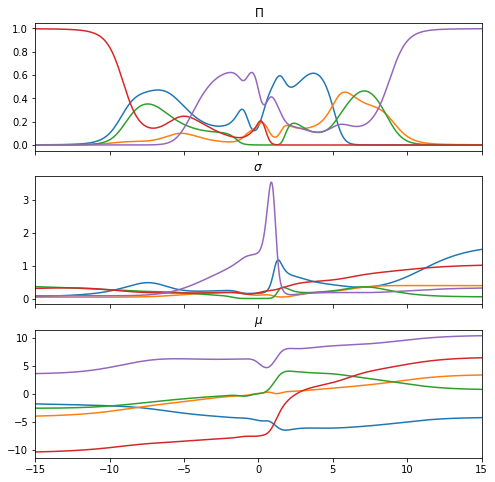

In [48]:
pi_variable, sigma_variable, mu_variable = network(x_test_variable)

pi_data = pi_variable.data.numpy()
sigma_data = sigma_variable.data.numpy()
mu_data = mu_variable.data.numpy()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,8))
ax1.plot(x_test_data, pi_data)
ax1.set_title('$\Pi$')
ax2.plot(x_test_data, sigma_data)
ax2.set_title('$\sigma$')
ax3.plot(x_test_data, mu_data)
ax3.set_title('$\mu$')
plt.xlim([-15,15])
plt.show()

We can also plot the $\mu$ of each Gaussian with respect to $x$, and show the range of by highlighting a region between $\mu-\sigma$ and $\mu+\sigma$.

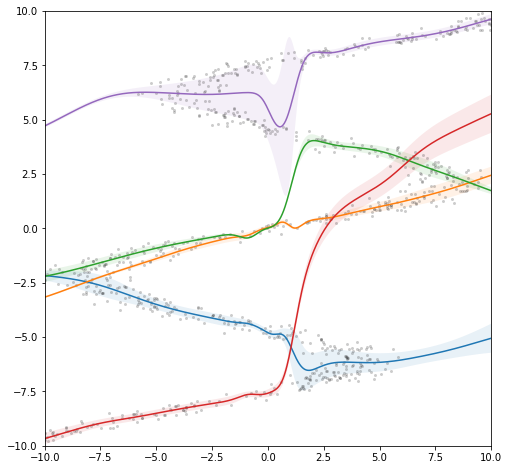

In [49]:
plt.figure(figsize=(8, 8), facecolor='white')
for mu_k, sigma_k in zip(mu_data.T, sigma_data.T):
    plt.plot(x_test_data, mu_k)
    plt.fill_between(x_test_data, mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)
plt.scatter(mdn_x_data, mdn_y_data, marker='.', lw=0, alpha=0.2, c='black')
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.show()

In the plot above, we see that for every point on the $x$-axis, there are multiple lines or states where $y$ may be, and we select these states with probabilities modelled by $\Pi$. Note that the network won't find an ideal solution every time. It's possible to get lower loss by using more Gaussians, but the results are harder to interpret.

If we want to sample from the network we will need to pick a Gaussian $k$ and pick a value (sample) from that Gaussian. Here we use a trick called [Gumbel softmax sampling](http://timvieira.github.io/blog/post/2014/07/31/gumbel-max-trick/) to pick our $k$. We treat the $\Pi$ weights as a discrete distribution of probabilities, and sample one $k$ for each row of `pi_data`.

In [50]:
def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

k = gumbel_sample(pi_data)

Now that we have selected $k$ for each row, we can select $\sigma$ and $\mu$ as well. We will use `np.random.randn` to sample from each Gaussian, scaling it by $\sigma$ and offsetting it by $\mu$.

In [51]:
indices = (np.arange(n_samples), k)
rn = np.random.randn(n_samples)
sampled = rn * sigma_data[indices] + mu_data[indices]

With these sampled $y$ values, we can overlay them on the original distribution to see how accurately the network captures the shape.

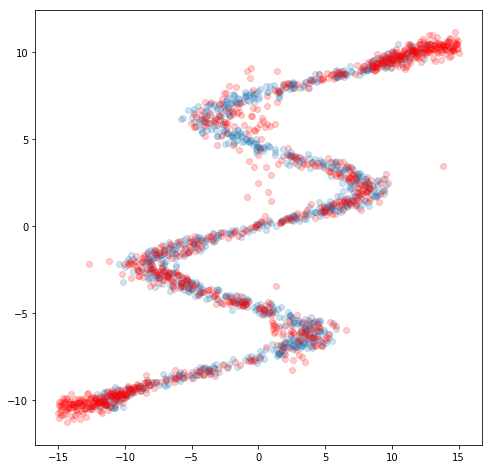

In [52]:
plt.figure(figsize=(8, 8))
plt.scatter(mdn_x_data, mdn_y_data, alpha=0.2)
plt.scatter(x_test_data, sampled, alpha=0.2, color='red')
plt.show()

Some other things to try:
    
- What other constraints might we enforce? Is it ever helpful to encourage $\Pi$ to be sparse to maintain a "simple" distribution?
- What kinds of regularization can we add to the network?
- Often very small sigma can create problems, it might be helpful to add `sigma += 0.01` inside the MDN.
- How do more or fewer Gaussians affect the result?
- How do more or fewer hidden nodes affect the result?
- What other kinds of nonlinear activation functions work besides `Tanh()`? Try `Sigmoid()` too.
- How do these plots move if you draw them in realtime while the network is training?
- What happens when if you use the [*softplus*](https://en.wikipedia.org/wiki/Softplus) function for making the $\sigma$ positive, instead of $\exp(x)$?